# Hyper Parameter Tune

In this notebook we'll close the cycle and find the best parameters for the model that we built in previously. This process is called **Hyper Parameter Optimization** and involves some steps:

1. Choose a optimization metric.
2. Create a objective function to minimize/maximize.
3. Define a parameter search space.
4. Execute the paramter search.
5. Check the results. If the found parameters gives a satisfactory model performance, then we are done and proceed to use the model. Otherwise, get back to step 3 and repeat util you find a model that best suits your needs.

In this project will the [Optuna Framework](https://optuna.org/), one of the best Hyper Parameter Optimization framework out there. Personally, I like Optana for its easy to use (I'll see it in a bit), but there are other great libraries that serves the same purposes very well. Some examples are:

- [Hyperopt](http://hyperopt.github.io/hyperopt/)
- [Ray Tune](https://docs.ray.io/en/latest/tune/index.html)
- [Scikit-Optimize](https://scikit-optimize.github.io/stable/)
- Scikit-learn itself, through [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

With some adjustments, the concepts that will be presented are easily extendable for other frameworks as well. So, feel free to use test what I will do here with any other framework you want.

**OBSERVATION:** This notebook will certainly take a at least 2 hours to run if you run all the optimzation code. It's totally normal.

**OBSERVATION 2:** If you want to save time and just train the final model, begin by running this notebook until section [Hyperparameter Optimization with Optuna](#hyperparameter-optimization-with-optuna). After that jump right into section [Voting Regressor Update](#voting-regressor-update) and run the remaining cells.

In [10]:
import os.path as P
import pickle

import cloudpickle
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import sklearn
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor

In [11]:
sklearn.set_config(transform_output="pandas")

In [12]:
random_state = 42

# Data Loading

## Preprocessing Pipeline

Let's first load our preprocessing pipeline:


In [13]:
artifacts_root_dir = P.join(P.dirname(P.abspath("")), "artifacts")


In [14]:
preprocessing_pipeline_path = P.join(
    artifacts_root_dir, "preprocessing_pipeline.pickle"
)

with open(preprocessing_pipeline_path, "rb") as f:
    preprocessing_pipeline = pickle.load(f)

preprocessing_pipeline

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value=0.0),
                                                  ['condominium_fee', 'suites',
                                                   'parking_spots', 'bedrooms',
                                                   'bathrooms']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(),
                                                  ['annual_iptu_tax',
                                                   'usable_area'])],
                                   verbose_feature_names_out=False)),
                ('featureunion-1',
                 FeatureUnion(t...
                ('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x7fe7d5fae320>)),
                ('columntransformer-2',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['property_type']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['usable_area',
                                                   'neighborhood_general_tax_score'])],
                                   verbose_feature_names_out=False))])

In [15]:
target_transform_path = P.join(artifacts_root_dir, "target_transform.pickle")

with open(target_transform_path, "rb") as f:
    target_transform = pickle.load(f)

target_transform


FunctionTransformer(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>)

## Dataset

Let's also load the dataset


In [16]:
preprocessed_dataset_root_dir = P.join(P.dirname(P.abspath("")), "data", "processed")


In [17]:
df_file = P.join(preprocessed_dataset_root_dir, "sp_sales_data.parquet")

features = pd.read_parquet(df_file)
target = features.pop("sale_price")

display(features)
display(target)


,neighborhood,property_type,usable_area,bathrooms,suites,bedrooms,parking_spots,ad_date,condominium_fee,annual_iptu_tax
0,Jardim da Saude,Two-story House,388.0,3.0,1.0,4.0,6.0,2017-02-07,NaN,NaN
1,Vila Santa Teresa (Zona Sul),House,129.0,2.0,1.0,3.0,2.0,2016-03-21,NaN,NaN
2,Vila Olimpia,Apartament,80.0,2.0,1.0,3.0,2.0,2018-10-26,686.0,1610.0
3,Pinheiros,Apartament,94.0,1.0,0.0,3.0,2.0,2018-05-29,1120.0,489.0
4,Vila Santa Clara,Condominium,110.0,1.0,1.0,3.0,2.0,2018-04-16,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
88742,Vila Carmosina,Apartament,48.0,1.0,0.0,2.0,1.0,2017-10-07,244.0,0.0
88743,Bela Vista,Apartament,60.0,1.0,NaN,1.0,1.0,2017-12-13,273.0,86.0
88744,Liberdade,Apartament,53.0,2.0,1.0,2.0,1.0,2018-11-28,210.0,0.0
88745,Vila Lageado,Apartament,20.0,3.0,2.0,3.0,2.0,2019-02-06,NaN,NaN


0         700000
1         336000
2         739643
3         630700
4         385000
          ...   
88742     171150
88743     251999
88744     249782
88745     623000
88746    1820000
Name: sale_price, Length: 88747, dtype: int64

Let's also apply the data transformation pipeline.


In [18]:
transformed_features = preprocessing_pipeline.transform(features)
transformed_target = target_transform.transform(target)

display(transformed_features)
display(transformed_target)


,property_type_Apartament,property_type_Condominium,property_type_Flat,property_type_House,property_type_Penthouse,property_type_Residential Building,property_type_Studio Apartament,property_type_Two-story House,usable_area,neighborhood_general_tax_score,suites,parking_spots,bedrooms,bathrooms,has_suites,has_parking_spots,has_bedrooms,has_bathrooms,n_features
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.039322,3.167133,0.166667,0.857143,0.8,0.428571,1.0,1.0,1.0,1.0,1.00
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.229577,-0.203310,0.166667,0.285714,0.6,0.285714,1.0,1.0,1.0,1.0,1.00
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.491186,0.996450,0.166667,0.285714,0.6,0.285714,1.0,1.0,1.0,1.0,1.00
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.285254,0.605658,0.000000,0.285714,0.6,0.142857,0.0,1.0,1.0,1.0,0.75
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.049903,-0.336893,0.166667,0.285714,0.6,0.142857,1.0,1.0,1.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88742,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.961888,-0.350581,0.000000,0.142857,0.4,0.142857,0.0,1.0,1.0,1.0,0.75
88743,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.785375,-0.147720,0.177136,0.142857,0.2,0.142857,1.0,1.0,1.0,1.0,1.00
88744,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.888341,-0.193948,0.166667,0.142857,0.4,0.285714,1.0,1.0,1.0,1.0,1.00
88745,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.373752,-0.187093,0.333333,0.285714,0.6,0.428571,1.0,1.0,1.0,1.0,1.00


0        13.458836
1        12.724866
2        13.513923
3        13.354586
4        12.860999
           ...    
88742    12.050296
88743    12.437180
88744    12.428344
88745    13.342302
88746    14.414347
Name: sale_price, Length: 88747, dtype: float64

## Train/Test Split

As in the last notebook, we'll split the data into train (80% of the original data) and test (20% of the original data) sets.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    transformed_features, transformed_target, test_size=0.2, random_state=random_state
)

print([t.shape for t in (X_train, X_test, y_train, y_test)])


[(70997, 19), (17750, 19), (70997,), (17750,)]


# Hyperparameter Optimization with Optuna

Optuna uses a technique called [Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) to find the best parameters for you model. To put it simply, it **learns** the best parameters combinations by, first, computing the value of an **objective function** given some random combination of parameters and, by checking the variation of the objetive function, finding the best optimization path. It them computes some new random combinations of hyperparameters that are closer to an optimal objective function value. This process is repeated some times until some stop criteria is met.

Usually, the **objective function** is the value of the evaluation metric (in our case, the Mean Squared Logarithmic Error) of our model trained with the given set of hyperparameters.

Now, we'll find the best parameters for each of the models that compose the **voting classifier** that we've trained in the last notebook.


## CatBoost Regressor

First, we need to choose which hyperparameters we want to optimize. Here's a description of the hyperparameters that I've chosen.


### Hyperparameters Descriptions

- **Number of Trees** (`iterations`): The maximum number of trees that can be built within the model. Represents the steps (or rounds of refinement) the algorithm takes to create a more accurate model that learns from the data. We'll use a fixed number, as we'll be also tuning the `learning_rate`.
- **Learning Rate** (`learning_rate`): Technically, is used for reducing the gradient step. In other words, it scales the contribution of each decision tree to manage the overall balance and accuracy of the model. A range of 0.02 to 0.7 is a good starting point.
- **Tree Depth** (`depth`): Depth of the tree. You can think as the complexity or “height” of decision trees in your CatBoost model. We'll try out values between 8 and 10
- **Subsample** (`subsample`): is a technique used to randomly choose a fraction of the dataset when constructing each tree, promoting diversity among the trees and helping to reduce overfitting. We'll from 0.9 to 1.0.
- **Feature Sampling by Level** (`colsample_bylevel`): The percentage of features to use at each split selection. The idea is the same as with `subsample`, but this time, we’re sampling features instead of rows. We'll use values between 0.5 and 0.7.
- **Minimum Data in Leaf** (`min_data_in_leaf`): The minimum number of training samples in a leaf, effectively controlling the split creation process. We'll go for values between 220 and 230.


### Objective function

With the hyperparameters and search space chosen, it's time to define the objective function.


In [30]:
def catboost_objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [1750, 2000, 2250]),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3, log=True),
        "depth": trial.suggest_categorical("depth", [7, 8, 9]),
        "subsample": trial.suggest_float("subsample", 0.75, 0.9),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.85, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 125),
    }

    model = CatBoostRegressor(
        **params, silent=True, allow_writing_files=False, random_seed=random_state
    )

    scorer = make_scorer(mean_squared_error)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)

    avg_msle = scores.mean()
    return avg_msle

Let's take a minute to analyze this code.


```python
def catboost_objective(trial):
```

Every objective function in Optuna receives a **Trial** object, that will hold all relevant information for a specific run of the function. E.g.: The hyperparameter combination set, timestamp of the function call, id of the call, etc.


```python
    params = {
        "iterations": trial.suggest_categorical("iterations", [1750, 2000, 2250]),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3, log=True),
        "depth": trial.suggest_categorical("depth", [7, 8, 9]),
        "subsample": trial.suggest_float("subsample", 0.75, 0.9),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.85, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 125),
    }
```

The search spaces in Optuna are defined inside the objective function. The **Trial** object will take care of "suggesting" the hyperparameters combination for the function call.


```python
    model = cb.CatBoostRegressor(
        **params, silent=True, allow_writing_files=False, random_seed=random_state
    )
```

Here the hyperparameters combination is supplied to the model (the `**` unpacks the `dict` items as function parameters). We also supply the parameters `silent=True` and `allow_writing_files=False` (that instructs the CatBoost regressor to not generate the training output files, we don't them), and the `random_seed` as weel, to ensure the reproductibility of the results.


```python
    scorer = make_scorer(mean_squared_error)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)

    avg_msle = scores.mean()
    return avg_msle
```

Next we compute the cross validation scores for 5-folds using the trainning set, compute the average score and return it.


### Optimization

With the objective function defined, we'll proceed to create the **Study**. In Optuna, the **Study** represents an optimization session, which comprises, among other things, the set of **Trials** objects.

The **Study** object also receives the `direction` parameter, that indicates if type of optimization we want: minimization or maximization. In our case, we want to minimize the error.

The **Study** is also responsible for the optimization process, by calling `optimize`.


In [31]:
catboost_study = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state)
)
catboost_study.optimize(catboost_objective, n_trials=30)

[I 2023-08-09 21:59:57,940] A new study created in memory with name: no-name-cdfc1afb-5721-4bd0-a51b-b8c4aec52bd4
[I 2023-08-09 22:00:27,363] Trial 0 finished with value: 0.04545540166057831 and parameters: {'iterations': 2000, 'learning_rate': 0.19303350086293308, 'depth': 7, 'subsample': 0.8799264218662403, 'colsample_bylevel': 0.9401672517614813, 'min_data_in_leaf': 118}. Best is trial 0 with value: 0.04545540166057831.
[I 2023-08-09 22:01:16,672] Trial 1 finished with value: 0.04524893893047423 and parameters: {'iterations': 2000, 'learning_rate': 0.1262732920146368, 'depth': 9, 'subsample': 0.8287134647448356, 'colsample_bylevel': 0.9147917527963173, 'min_data_in_leaf': 107}. Best is trial 1 with value: 0.04524893893047423.
[I 2023-08-09 22:01:47,826] Trial 2 finished with value: 0.04532767090131781 and parameters: {'iterations': 1750, 'learning_rate': 0.14955434061021924, 'depth': 8, 'subsample': 0.8271351657620417, 'colsample_bylevel': 0.9388621853293063, 'min_data_in_leaf': 101

With the process finished, we can retrieve the found set of best parameters, as well of the optimizal value of the objective function.


In [32]:
print("Best hyperparameters: ", catboost_study.best_params)
print("Best MSLE", catboost_study.best_value)


Best hyperparameters:  {'iterations': 2250, 'learning_rate': 0.11540701856608257, 'depth': 9, 'subsample': 0.8567966703320118, 'colsample_bylevel': 0.8815286672349768, 'min_data_in_leaf': 120}
Best MSLE 0.04507567952381386


Now we can train the CatBoost regressor with the best hyperparameters and evaluate the resulting model error using the test set.


In [33]:
catboost_model = CatBoostRegressor(
    **catboost_study.best_params,
    silent=True,
    allow_writing_files=False,
    random_seed=random_state
)
catboost_model.fit(X_train, y_train)
catboost_predictions = catboost_model.predict(X_test)
mean_squared_error(y_test, catboost_predictions)


0.043878406988275116

This is already an improvement of the voting classifier that we've trained in the last notebook.

Next, we'll proceed to execute the same parameter optimization process for the **XGBoost**, **Random Forest** and **LightGBM** regression models.


## XGBoost Regressor

As we did with the CatBoost regressor, we'll describe the hyperparameters that we want to optimize.


### Hyperparameters Descriptions

- **Number of estimators** (`n_estimators`): Similar to CatBoostm, is the maximum number of trees that can be built within the model. We'll also use a fixed number.
- **Max depth** (`max_depth`): Also similar to the CatBoost. We'll use values between 9 and 11.
- **Subsample** (`subsample`): Also similar to the CatBoost. We'll use values between 0.7 to 1.
- **Learning rate** (`learning_rate`): Also similar to the CatBoost. We'll use values between 0.001 to 0.1.
- **ColSample by level** (`colsample_bylevel`): Also similar to the CatBoost. We'll use values between 0.4 to 0.65.
- **Min child weight** (`min_child_weight`): That is the most different than those we've talked about. Defines the minimum sum of weights of all observations required in a child, and is used to control over-fitting. Higher values prevent a model from learning relations that might be highly specific to the particular sample selected for a tree.


### Objective function


In [15]:
def xgboost_objective(trial):
    params = {
        "n_estimators": 800,
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.07, log=True),
        "max_depth": trial.suggest_categorical("max_depth", [9, 10, 11]),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "min_child_weight": trial.suggest_categorical("min_child_weight", [1, 2, 6, 10]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.4, 0.65),
    }

    model = XGBRegressor(**params, random_state=random_state)

    scorer = make_scorer(mean_squared_error)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)

    avg_msle = scores.mean()
    return avg_msle

### Optimization


In [16]:
xgboost_study = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state)
)
xgboost_study.optimize(xgboost_objective, n_trials=30)

[I 2023-07-20 01:37:09,474] A new study created in memory with name: no-name-53479503-7f2a-45a8-953b-412369c76648
[I 2023-07-20 01:37:59,439] Trial 0 finished with value: 0.03818054590837362 and parameters: {'n_estimators': 750, 'learning_rate': 0.049821142116210686, 'max_depth': 9, 'subsample': 0.9598528437324805, 'min_child_weight': 10, 'colsample_bylevel': 0.6081106602001054}. Best is trial 0 with value: 0.03818054590837362.
[I 2023-07-20 01:38:45,852] Trial 1 finished with value: 0.038896721068480924 and parameters: {'n_estimators': 700, 'learning_rate': 0.038821770442787056, 'max_depth': 9, 'subsample': 0.8835558684167139, 'min_child_weight': 10, 'colsample_bylevel': 0.5962939903482534}. Best is trial 0 with value: 0.03818054590837362.
[I 2023-07-20 01:39:41,512] Trial 2 finished with value: 0.03849831574633579 and parameters: {'n_estimators': 800, 'learning_rate': 0.031204262902541264, 'max_depth': 9, 'subsample': 0.984665661176, 'min_child_weight': 1, 'colsample_bylevel': 0.5710

In [17]:
print("Best hyperparameters: ", xgboost_study.best_params)
print("Best MSLE", xgboost_study.best_value)

Best hyperparameters:  {'n_estimators': 800, 'learning_rate': 0.050785730089942624, 'max_depth': 11, 'subsample': 0.9628796517316951, 'min_child_weight': 1, 'colsample_bylevel': 0.5459237341141532}
Best MSLE 0.037100172390475


In [18]:
xgboost_model = XGBRegressor(**xgboost_study.best_params, random_state=random_state)
xgboost_model.fit(X_train, y_train)
xgboost_predictions = xgboost_model.predict(X_test)
mean_squared_error(y_test, xgboost_predictions)

0.0360436848319693

Wonderful! Now XGBoost regressor is also better than the voting regressor.


## Random Forest Regressor


### Hyperparameter Descriptions

- **Number of estimators** (`n_estimators`):Similar to CatBoostm, is the maximum number of trees that can be built within the model.
- **Depth** (`max_depth`): Also similar to the CatBoost.
- **Min samples leaf** (`min_samples_leaf`): The minimum number of samples required to be at a leaf node.
- **Min samples split** (`min_samples_split`): The minimum number of samples required to split an internal node

### Objective Function


In [19]:
def random_forest_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 450, 550),
        "max_depth": trial.suggest_int("max_depth", 35, 45),
        'min_samples_leaf': trial.suggest_categorical("min_samples_leaf", [2, 3]),
        'min_samples_split': trial.suggest_categorical("min_samples_split", [2, 3]),
    }

    model = RandomForestRegressor(**params, n_jobs=-1, random_state=random_state)

    scorer = make_scorer(mean_squared_error)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)

    avg_msle = scores.mean()
    return avg_msle


### Optimization


In [20]:
random_forest_study = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state)
)
random_forest_study.optimize(random_forest_objective, n_trials=30)

[I 2023-07-20 02:08:57,040] A new study created in memory with name: no-name-cae6ad06-3b60-47ca-8e0b-0213d26391e5
[I 2023-07-20 02:10:00,573] Trial 0 finished with value: 0.04733135751301269 and parameters: {'n_estimators': 487, 'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 2}. Best is trial 0 with value: 0.04733135751301269.
[I 2023-07-20 02:10:56,130] Trial 1 finished with value: 0.0482183419476848 and parameters: {'n_estimators': 455, 'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.04733135751301269.
[I 2023-07-20 02:12:01,169] Trial 2 finished with value: 0.04818650881232302 and parameters: {'n_estimators': 534, 'max_depth': 37, 'min_samples_leaf': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.04733135751301269.
[I 2023-07-20 02:13:05,515] Trial 3 finished with value: 0.04732983032898498 and parameters: {'n_estimators': 493, 'max_depth': 38, 'min_samples_leaf': 2, 'min_samples_split': 3}. Best is trial 3 with

In [21]:
print("Best hyperparameters: ", random_forest_study.best_params)
print("Best MSLE", random_forest_study.best_value)

Best hyperparameters:  {'n_estimators': 548, 'max_depth': 39, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best MSLE 0.04730910423852842


In [22]:
random_forest_model = RandomForestRegressor(
    **random_forest_study.best_params, random_state=random_state
)
random_forest_model.fit(X_train, y_train)
random_forest_model_predictions = random_forest_model.predict(X_test)
mean_squared_error(y_test, random_forest_model_predictions)

0.04500350101877825

The improvement wasn't that much. Let's hope the improvement in other models be sufficient.


## LightGbm Regressor

At this point, the parameters that we'll optimize in the LightGBM regressor all have their respective counterparts in previous models and were already explained. So let's jump in the optimization function right away.


### Optimization Function


In [23]:
def lightgbm_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 2230, 2260),
        "max_depth": trial.suggest_int("max_depth", 17, 23),
        "num_leaves": trial.suggest_int("num_leaves", 45, 55),
        "subsample": trial.suggest_float("subsample", 0.3, 0.6),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.75),
    }

    model = LGBMRegressor(**params, n_jobs=-1, random_state=random_state)

    scorer = make_scorer(mean_squared_error)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)

    avg_msle = scores.mean()
    return avg_msle


### Optimization


In [24]:
lightgbm_study = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state)
)
lightgbm_study.optimize(lightgbm_objective, n_trials=30)

[I 2023-07-20 02:45:05,383] A new study created in memory with name: no-name-96222659-5076-4df0-a07b-f137a22efd1f
[I 2023-07-20 02:45:26,305] Trial 0 finished with value: 0.03854269046915933 and parameters: {'n_estimators': 2241, 'max_depth': 23, 'num_leaves': 53, 'subsample': 0.47959754525911097, 'colsample_bytree': 0.5390046601106091}. Best is trial 0 with value: 0.03854269046915933.
[I 2023-07-20 02:45:47,094] Trial 1 finished with value: 0.03860250977167544 and parameters: {'n_estimators': 2234, 'max_depth': 17, 'num_leaves': 54, 'subsample': 0.4803345035229626, 'colsample_bytree': 0.6770181444490113}. Best is trial 0 with value: 0.03854269046915933.
[I 2023-07-20 02:46:07,391] Trial 2 finished with value: 0.03849363519097731 and parameters: {'n_estimators': 2230, 'max_depth': 23, 'num_leaves': 54, 'subsample': 0.3637017332034828, 'colsample_bytree': 0.5454562418017752}. Best is trial 2 with value: 0.03849363519097731.
[I 2023-07-20 02:46:26,737] Trial 3 finished with value: 0.0385

In [25]:
print("Best hyperparameters: ", lightgbm_study.best_params)
print("Best MSLE", lightgbm_study.best_value)

Best hyperparameters:  {'n_estimators': 2256, 'max_depth': 20, 'num_leaves': 49, 'subsample': 0.3370342950671986, 'colsample_bytree': 0.6169156857265662}
Best MSLE 0.03837866262574901


In [26]:
lightgbm_model = LGBMRegressor(**lightgbm_study.best_params, random_state=random_state)
lightgbm_model.fit(X_train, y_train)
lightgbm_model_predictions = lightgbm_model.predict(X_test)
mean_squared_error(y_test, lightgbm_model_predictions)

0.03771991159041149

How about that! LightGBM regressor, the least performant model of the previous notebook, for this experiment, is now the best one. Sure, our approach was rather simplistic, and is not sufficient to tell if this model is really the best one. But, to not extended this study more than necessary, we'll accept these results as they are.


# Voting Regressor Update

As before, we'll build our final final as a combination of the four models that we've discussed here, but, this time, they are optimized for our problem.

## Optimized Models

For simplicity and time saving, I'll repost the all models with the optimal parameters that I found in my tests. Instead of  running all the optimization code above, you just need to run the following cell.

In [11]:
catboost_model = CatBoostRegressor(
    **{
        "learning_rate": 0.13425288328811075,
        "depth": 9,
        "subsample": 0.9199702825574229,
        "colsample_bylevel": 0.572827994601722,
        "min_data_in_leaf": 225.63038175724117,
    },
    allow_writing_files=False,
    silent=True,
    random_seed=random_state
)

xgboost_model = XGBRegressor(
    **{
        "n_estimators": 800,
        "learning_rate": 0.050785730089942624,
        "max_depth": 11,
        "subsample": 0.9628796517316951,
        "min_child_weight": 1,
        "colsample_bylevel": 0.5459237341141532,
    },
    random_state=random_state
)

random_forest_model = RandomForestRegressor(
    **{
        "n_estimators": 548,
        "max_depth": 39,
        "min_samples_leaf": 2,
        "min_samples_split": 2,
    },
    n_jobs=-1,
    random_state=random_state
)

lightgbm_model = LGBMRegressor(
    **{
        "n_estimators": 2256,
        "max_depth": 20,
        "num_leaves": 49,
        "subsample": 0.3370342950671986,
        "colsample_bytree": 0.6169156857265662,
    },
    n_jobs=-1,
    random_state=random_state
)

In [12]:
voting_regressor = VotingRegressor(
    estimators=[
        (model.__class__.__name__, model)
        for model in (
            catboost_model,
            xgboost_model,
            random_forest_model,
            lightgbm_model,
        )
    ],
)

voting_regressor.fit(X_train, y_train)
voting_regressor_predictions = voting_regressor.predict(X_test)
mean_squared_error(y_test, voting_regressor_predictions)

0.03650454638989949

The error reduction wasn't that much this. Actually, if I were to choose, I would stick with the LightGBM Regressor or try different hyperparameter search spaces for the other models before using this model in a production environment, for example. But, for the sake of simplicity, we'll accept this model as the best one


## Training with the whole dataset

Now it's time to check how our regressor fares with the entire dataset.


In [13]:
voting_regressor.fit(transformed_features, transformed_target)


VotingRegressor(estimators=[('CatBoostRegressor',
                             <catboost.core.CatBoostRegressor object at 0x7f0d682cf6d0>),
                            ('XGBRegressor',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=0.5459237341141532,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          ga...
                                          n_estimators=800, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...)),
                            ('RandomForestRegressor',
                             RandomForestRegressor(max_depth=39,
                                                   min_samples_leaf=2,
                                                   n_estimators=548, n_jobs=-1,
                                                   random_state=42)),
                            ('LGBMRegressor',
                             LGBMRegressor(colsample_bytree=0.6169156857265662,
                                           max_depth=20, n_estimators=2256,
                                           num_leaves=49, random_state=42,
                                           subsample=0.3370342950671986))])

In [14]:
all_predictions = voting_regressor.predict(transformed_features)
mean_squared_error(transformed_target, all_predictions)

0.013201891396805714

OK. The error between the predictions and the transformed target is very small indeed. But we have to remember that the transformed target is, actually, the log value of the real house prices.

So, let's check how the error really behaves if we apply the **inverse transform** to the target (in this case, exponential function).


In [15]:
transformed_predictions = target_transform.inverse_transform(all_predictions)
mean_absolute_error(target, transformed_predictions)

46283.019718185635

An average error of R$46283,02? Let's take a better look at the behavior of the error:

In [16]:
errors = pd.DataFrame()
errors["property_type"] = features["property_type"]
errors["error"] = target - transformed_predictions
errors


,property_type,error
0,Two-story House,-67406.486467
1,House,-81263.927538
2,Apartament,16152.785139
3,Apartament,-38642.464728
4,Condominium,10690.010690
...,...,...
88742,Apartament,7720.245652
88743,Apartament,-53236.363523
88744,Apartament,-46696.713556
88745,Apartament,35867.578890


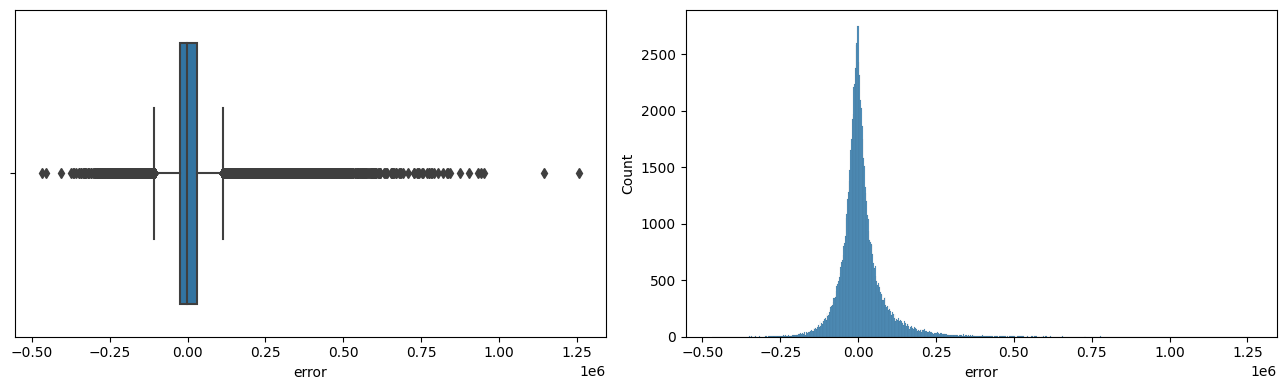

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 4))

sns.boxplot(x="error", data=errors, ax=ax1)
sns.histplot(x="error", data=errors, ax=ax2)

plt.tight_layout();

as we can see, we still have some significant errors, but now their magnitudes  are a bit lower (both plot are "squeezed" with relation to the corresponding graph of the last notebook model).

Let's take a better look at the error behavior with relation to the property types.

### Error Analysis by Property Type

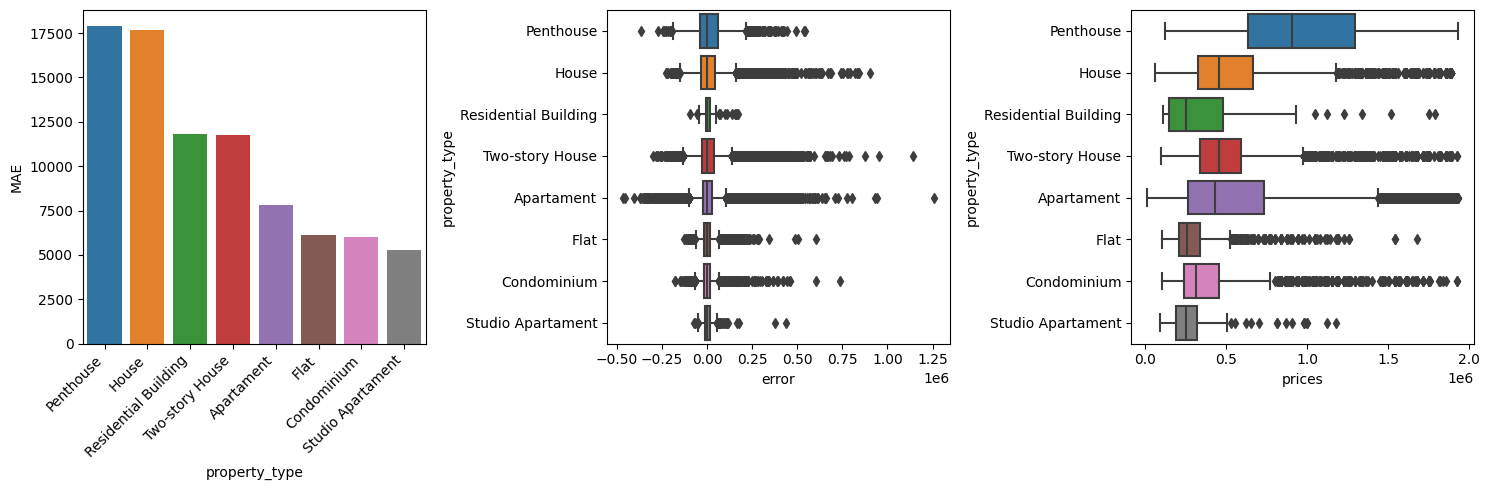

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(15, 5))

maes = errors.groupby("property_type").agg(MAE=("error", np.average)).sort_values("MAE", ascending=False)
sns.barplot(x=maes.index, y="MAE", data=maes, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

sns.boxplot(x="error", y="property_type", data=errors, order=maes.index, ax=ax2)

prices = pd.DataFrame()
prices["property_type"] = features["property_type"]
prices["prices"] = target
sns.boxplot(x="prices", y="property_type", order=maes.index, data=prices, ax=ax3)

plt.tight_layout();

- The overall errors have decreased, as the highest property type error (**Penthouses**) is now almost half of the highest property error of the last notebook.
- The three higher average error continue to be **residential buildings**, **penthouses'** and **houses**.
- Now, **houses** have the highest error variation.

# Exporting the Final Model

We'reached the end of our data analysis and model design. With those steps we've followed we can tackle almost any Data Science project.

Now it's time to export our final model, so we can use it in the API service that we'll build. For this, we'll use [cloudpickle](https://github.com/cloudpipe/cloudpickle) once again.

In [19]:
model_path = P.join(
    artifacts_root_dir, "regression_model.pickle"
)

with open(model_path, "wb") as f:
    cloudpickle.dump(voting_regressor, f)

And that's it. With our model exporte, we can put it to good use.